# Data

In [1]:
# load the packages
from pyimagesearch import config
from pyimagesearch import top
from pyimagesearch.resnet import ResNet
from imutils import paths
import random
import shutil
import os
import cv2
import re
from itertools import chain

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler
from keras.optimizers import SGD
from keras import optimizers
from keras.applications import VGG16
from keras.models import Sequential
from keras import layers
from keras.layers import Dense, Activation
from keras.callbacks import EarlyStopping
import keras.backend as K
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, cohen_kappa_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

sns.set_style('white')
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 100)
SEED = 42

Using TensorFlow backend.
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py

## Load Item Data

In [2]:
# import item
items = pd.read_csv("data/Taobao Clothes Matching Data/dim_items(new).txt", sep='delimiter', header=None)
items = items[0].apply(lambda x: x.split())
item_df = pd.DataFrame()
item_df['item_id'] = items.apply(lambda x: x[0])
item_df['cat_id'] = items.apply(lambda x: x[1])
item_df['terms'] = items.apply(lambda x: x[2:])
item_df.head()

,item_id,cat_id,terms
0,29,155,"[123950,53517,106068,59598,7503,171811,25618,1..."
1,49,228,"[73035,33202,116593,48909,92233,181255,127004,..."
2,59,284,"[123950,38910,22837,5026,15459,47776,158346,10..."
3,109,461,"[122071,35420,123950,27207,116593,24893,31897,..."
4,119,368,"[48909,125706,116593,179606,20819,158346,15722..."


In [3]:
item_df.shape

(499983, 3)

In [4]:
# number of categories
item_df.cat_id.nunique()

281

In [5]:
top_cat = item_df.cat_id.value_counts()[:20]
top_cat

368    59380
52     41859
284    32080
461    28388
111    27604
505    19985
48     19348
155    17720
228    17617
160    15930
137    15735
33     15638
42     15003
516    13285
50     12451
453    10865
178    10146
81      9050
311     8895
522     7878
Name: cat_id, dtype: int64

In [6]:
top_item_df = item_df.loc[item_df.cat_id.isin(top_cat.index), ['item_id', 'cat_id']]
top_item_df.shape

(398857, 2)

In [7]:
top_item = list(top_item_df.item_id)
top_item

['29',
 '49',
 '59',
 '109',
 '119',
 '179',
 '264',
 '374',
 '414',
 '424',
 '444',
 '489',
 '494',
 '499',
 '504',
 '559',
 '569',
 '619',
 '774',
 '789',
 '814',
 '864',
 '874',
 '894',
 '959',
 '964',
 '1019',
 '1029',
 '1049',
 '1059',
 '1174',
 '1279',
 '1359',
 '1429',
 '1439',
 '1484',
 '1509',
 '1534',
 '1634',
 '1644',
 '1694',
 '1734',
 '1749',
 '1854',
 '1879',
 '1909',
 '1979',
 '1984',
 '1999',
 '2114',
 '2134',
 '2149',
 '2234',
 '2259',
 '2264',
 '2279',
 '2284',
 '2314',
 '2354',
 '2364',
 '2394',
 '2399',
 '2414',
 '2419',
 '2439',
 '2474',
 '2514',
 '2519',
 '2569',
 '2629',
 '2669',
 '2674',
 '2744',
 '2904',
 '2914',
 '3054',
 '3094',
 '3114',
 '3119',
 '3139',
 '3169',
 '3219',
 '3249',
 '3334',
 '3344',
 '3359',
 '3364',
 '3459',
 '3544',
 '3549',
 '3604',
 '3609',
 '3624',
 '3644',
 '3704',
 '3724',
 '3734',
 '3844',
 '3849',
 '3854',
 '3859',
 '3869',
 '3929',
 '3944',
 '3974',
 '4024',
 '4049',
 '4199',
 '4289',
 '4294',
 '4324',
 '4344',
 '4384',
 '4394',
 '4

## Filter Image

Filter for items in the top 20 categories.

In [8]:
# initialize the path to the *original* input directory of images
ORIG_INPUT_DATASET = 'data/tianchi_fm_img2_1'

# initialize the base path to the *new* directory that will contain our images after computing the training and testing split
BASE_PATH = 'data'

# filter path
FILTER_PATH = os.path.sep.join([BASE_PATH, 'filter'])

# create the directory
if not os.path.exists(top.FILTER_PATH):
        print("[INFO] 'creating {}' directory".format(FILTER_PATH))
        os.makedirs(FILTER_PATH)

In [9]:
# loop over the input image paths
imagePaths = list(paths.list_images(ORIG_INPUT_DATASET))

for inputPath in imagePaths:

    # extract the filename of the input image along with its corresponding class label
    filename = inputPath.split(os.path.sep)[-1]
    file_id = filename.split('.')[0]
    if file_id in top_item:
        label = top_item_df.loc[top_item_df.item_id==file_id, 'cat_id'].values[0]
        # build the path to the label directory
        labelPath = os.path.sep.join([FILTER_PATH, label])

        # if the label output directory does not exist, create it
        if not os.path.exists(labelPath):
            print("[INFO] 'creating {}' directory".format(labelPath))
            os.makedirs(labelPath)

        # construct the path to the destination image and then copy the image itself
        p = os.path.sep.join([labelPath, filename])
        shutil.copy2(inputPath, p)

[INFO] 'creating data/filter/284' directory
[INFO] 'creating data/filter/48' directory
[INFO] 'creating data/filter/33' directory
[INFO] 'creating data/filter/461' directory
[INFO] 'creating data/filter/50' directory
[INFO] 'creating data/filter/178' directory
[INFO] 'creating data/filter/311' directory
[INFO] 'creating data/filter/81' directory
[INFO] 'creating data/filter/160' directory
[INFO] 'creating data/filter/368' directory
[INFO] 'creating data/filter/42' directory
[INFO] 'creating data/filter/52' directory
[INFO] 'creating data/filter/155' directory
[INFO] 'creating data/filter/228' directory
[INFO] 'creating data/filter/505' directory
[INFO] 'creating data/filter/522' directory
[INFO] 'creating data/filter/453' directory
[INFO] 'creating data/filter/111' directory
[INFO] 'creating data/filter/516' directory
[INFO] 'creating data/filter/137' directory


## Train, Val, Test Split

In [18]:
# initialize the path to the *original* input directory of images
ORIG_INPUT_DATASET = 'data/filter'

# initialize the base path to the *new* directory that will contain our images after computing the training and testing split
BASE_PATH = 'data'

# derive the training, validation, and testing directories
TRAIN_PATH = os.path.sep.join([BASE_PATH, 'training'])
VAL_PATH = os.path.sep.join([BASE_PATH, 'validation'])
TEST_PATH = os.path.sep.join([BASE_PATH, 'testing'])

# define the amount of data that will be used training
TRAIN_SPLIT = 0.8

# the amount of validation data will be a percentage of the *training* data
VAL_SPLIT = 0.1

In [19]:
# grab the paths to all input images in the original input directory and shuffle them
imagePaths = list(paths.list_images(ORIG_INPUT_DATASET))
random.seed(42)
random.shuffle(imagePaths)

In [20]:
# compute the training and testing split
i = int(len(imagePaths) * TRAIN_SPLIT)
trainPaths = imagePaths[:i] # 80% of the data
testPaths = imagePaths[i:] # 20% of the data

# we'll be using part of the training data for validation
i = int(len(trainPaths) * VAL_SPLIT)
valPaths = trainPaths[:i] # 8% of the data
trainPaths = trainPaths[i:] #72% of the data

In [21]:
# define the datasets that we'll be building
datasets = [
    ('training', trainPaths, TRAIN_PATH),
    ('validation', valPaths, VAL_PATH),
    ('testing', testPaths, TEST_PATH)
]

In [22]:
# loop over the datasets
for (dType, imagePaths, baseOutput) in datasets:
    
    # show which data split we are creating
    print("[INFO] building '{}' split".format(dType))
    
    # if the output base output directory does not exist, create it
    if not os.path.exists(baseOutput):
        print("[INFO] 'creating {}' directory".format(baseOutput))
        os.makedirs(baseOutput)
        
    # loop over the input image paths
    for inputPath in imagePaths:
        
        # extract the filename of the input image along with its corresponding class label
        filename = inputPath.split(os.path.sep)[-1]
        label = inputPath.split(os.path.sep)[-2]

        # build the path to the label directory
        labelPath = os.path.sep.join([baseOutput, label])

        # if the label output directory does not exist, create it
        if not os.path.exists(labelPath):
            print("[INFO] 'creating {}' directory".format(labelPath))
            os.makedirs(labelPath)
            
        # construct the path to the destination image and then copy the image itself
        p = os.path.sep.join([labelPath, filename])
        shutil.copy2(inputPath, p)

[INFO] building 'training' split
[INFO] 'creating data/training/228' directory
[INFO] 'creating data/training/516' directory
[INFO] 'creating data/training/52' directory
[INFO] 'creating data/training/284' directory
[INFO] 'creating data/training/461' directory
[INFO] 'creating data/training/42' directory
[INFO] 'creating data/training/522' directory
[INFO] 'creating data/training/48' directory
[INFO] 'creating data/training/50' directory
[INFO] 'creating data/training/155' directory
[INFO] 'creating data/training/368' directory
[INFO] 'creating data/training/178' directory
[INFO] 'creating data/training/137' directory
[INFO] 'creating data/training/111' directory
[INFO] 'creating data/training/311' directory
[INFO] 'creating data/training/160' directory
[INFO] 'creating data/training/81' directory
[INFO] 'creating data/training/505' directory
[INFO] 'creating data/training/453' directory
[INFO] 'creating data/training/33' directory
[INFO] building 'validation' split
[INFO] 'creating d

In [23]:
# determine the total number of image paths in training, validation, and testing directories
totalTrain = len(list(paths.list_images(TRAIN_PATH)))
totalVal = len(list(paths.list_images(VAL_PATH)))
totalTest = len(list(paths.list_images(TEST_PATH)))

print(totalTrain)
print(totalVal)
print(totalTest)

68904
7655
19140


In [24]:
def load_images(folder):
    images = {}
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            images[filename.split('.')[0]] = img
    return images

In [25]:
train_228 = load_images('data/training/228')

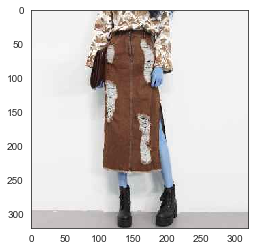

In [27]:
plt.imshow(train_228[list(train_228.keys())[1]])